# Notebook to format Yellowstone cougar data
# Adapted from "A public domain dataset for human activity recognition using smartphones", Anguita et al (2013).

Data can be found [here](https://doi.org/10.24432/C54S4K).

[Leaderboard](https://paperswithcode.com/dataset/har)

[Paper](https://www.esann.org/sites/default/files/proceedings/legacy/es2013-84.pdf)

## Outputs:
- dataset_metadata (yaml)
- clip_data (directory of csv files)
- class_rep (yaml)

# Setup

In [170]:
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import glob
import yaml
import scipy.signal as signal

We first set up directories where datafiles and metadata will be stored

In [171]:
# Specify data filepaths, and set up directories where we will save files

# +/- 6 hours either side of kill, each cat's kills split in half (to create illusion of more cats)
# raw_data_dir = '/home/matthew/AI_Capstone/ai-capstone/BEBE-datasets/raw_cougar_split/'
# formatted_data_dir = '/home/matthew/AI_Capstone/ai-capstone/BEBE-datasets/format_cougar_split/'

# +/- 1 hour either side of kill, each cat's kills split in half (to create illusion of more cats)
raw_data_dir = '/home/matthew/AI_Capstone/ai-capstone/BEBE-datasets/raw_cougar_2hr_window/'
formatted_data_dir = '/home/matthew/AI_Capstone/ai-capstone/BEBE-datasets/format_cougar_2hr_window/'


if not os.path.exists(formatted_data_dir):
    os.makedirs(formatted_data_dir)
    
acc_fps = glob.glob(raw_data_dir + '/RawData/acc*.txt')

clip_data_dir = os.path.join(formatted_data_dir, 'clip_data')
if not os.path.exists(clip_data_dir):
    os.makedirs(clip_data_dir)

Dataset metadata is kept in a dictionary for now. All entries in the dataset metadata are read by the main scripts in BEBE, and are required.

In [172]:
# Dataset metadata is tracked as a dictionary

dataset_metadata = {}
sr = 16 # sampling rate, in Hz
dataset_metadata['sr'] = sr ## from dataset documentation
dataset_metadata['dataset_name'] = 'cougar'

Each contiguous chunk of data is a clip, and is associated with a unique clip_id. These clip ids will be used as filenames when saving formatted data

In [173]:
# Here we get clip_ids by drawing from the names of the pre-existing acc and gyr files.
## eg '/home/jupyter/behavior_data_local/data/raw/HAR/RawData/acc_exp58_user29.txt' -> 'exp58_user29'

acc_clip_ids = sorted(set([x.split('/')[-1].split('.')[0][4:] for x in acc_fps]))

clip_ids = acc_clip_ids
dataset_metadata['clip_ids'] = clip_ids

Each individual is given a number, beginning with 0 (skipped numbers are allowed but not preferred).
We also set up a dictionary `clip_id_to_individual_id` which is of the form `{clip_id : individual_id}`. This tells us which individual is represented in each clip

In [174]:
## Integer codes for individuals

clip_id_to_individual_id = {clip_id : int(clip_id.split('_')[1][4:]) for clip_id in clip_ids}
individuals = sorted({clip_id_to_individual_id[key] for key in clip_id_to_individual_id})

dataset_metadata['individual_ids'] = individuals # There are 14 individuals but only 13 mentioned in the paper
dataset_metadata['clip_id_to_individual_id'] = clip_id_to_individual_id

We divide the individuals into five folds

In [175]:
# Set up data splits: divide individuals across folds for cross validation

n_folds = 5
dataset_metadata['n_folds'] = n_folds
individuals_per_fold = {i : [] for i in range(n_folds)}

for pointer, individual in enumerate(individuals):
    individuals_per_fold[pointer % n_folds].append(individual)
    
dataset_metadata['individuals_per_fold'] = individuals_per_fold
    
print(individuals_per_fold)
print("There are %d individuals" % len(individuals))

{0: [2020, 2091], 1: [2021], 2: [2070], 3: [2071], 4: [2090]}
There are 6 individuals


We set up a dictionary `clip_ids_per_fold` which is of the form `{fold : list of clip_ids}`. It says in a given fold, which clip_ids are in that fold.

In [176]:
# Set up clip ids 

clip_ids_per_fold = {i : [] for i in range(n_folds)}
for clip_id in clip_ids:
    individual = clip_id_to_individual_id[clip_id]
    for fold in range(n_folds):
        if individual in individuals_per_fold[fold]:
            clip_ids_per_fold[fold].append(clip_id)
for fold in range(n_folds):
    clip_ids_per_fold[fold] = sorted(clip_ids_per_fold[fold])

dataset_metadata['clip_ids_per_fold'] = clip_ids_per_fold

We create a list of behavioral classes. By convention, the `unknown` class is always the first in this list, even if all data in the dataset has been annotated. The integer label associated with each behavior class name is equal to the index of that class name in this list

In [177]:
## Integer codes for specific behaviors

# list of behaviors, see activity_labels.txt
beh_names = ['unknown', 
             'STALKING',
             'KILLING',
             'FEEDING',
             'NON_KILL',
            ]

dataset_metadata['label_names'] = beh_names

def get_index_of_behavior(behavior):
    try:
        return int(beh_names.index(behavior))
    except ValueError:
        return 0

We name each data channel we will use. 

By convention, channels with the string `Acc` in their name will be pre-processed to separate static and dynamic acceleration. This uses a Butterworth filter, and the cutoff frequency of this filter is a hyperparameter specified during training.

By convention, the last two data channels must be `individual_id` (which is constant within a single clip) and `label`, respectively. These are both integer-valued.

In [179]:
## clip_data column names

clip_column_names = ['AccX', 'AccY', 'AccZ', 'label', 'individual_id',]
dataset_metadata['clip_column_names'] = clip_column_names

We save the metadata dictionary as a `.yaml` file. However, we will still need to reload it and edit it at the very end of this notebook when we can compute average annotation duration.

In [129]:
## Save off dataset level metadata

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(dataset_metadata, file)

## Format Clip Data

Now we are ready to format the data for BEBE. For each clip, we save the data from that clip as `clip_id.csv`. This file is a csv array without header. Its shape is `[num_sampled_time_steps, num_channels]`, where the `num_channels` is equal to the length of `dataset_metadata['clip_column_names']`.

In [75]:
# load up annotations (not needed when experiment data is already in CSVs)

# annotations_fp = os.path.join(raw_data_dir, 'RawData', 'labels.txt')
# annotations = pd.read_csv(annotations_fp, delimiter = ' ', header = None, names = ['exp_id','ind_id','label','start_sample','end_sample'])

In [169]:
# For each clip, create and save the data in the correct format

total_dur_samples = 0
total_annotation_dur_samples = 0

# includes timestamp
# header_names = ["UTC DateTime", "Milliseconds", "Acc X [g]", "Acc Y [g]", "Acc Z [g]", "Category"]
# excludes timestamp
header_names = ["Acc X [g]", "Acc Y [g]", "Acc Z [g]", "Category"]

for clip_id in clip_ids:
    # load features
    acc_fp = os.path.join(raw_data_dir, 'RawData', 'acc_' + clip_id + '.txt')
    
    acc_data = pd.read_csv(acc_fp, delimiter = ',', header = 1)
    
    clip_dur_samples = len(acc_data)
    total_dur_samples += clip_dur_samples
        
    exp_id = int(clip_id[3:5])
    # annotations_sub = annotations[annotations['exp_id'] == exp_id]
    
    # reformat annotations
    per_frame_annotations = np.zeros([clip_dur_samples, 1]) # populate with 0's, aka "unknown"
    # for i, row in annotations_sub.iterrows():
        # obs_int_label = row['label']
        # int_label = obs_int_label if obs_int_label < 7 else 0 # Treat transitional states as unknown
        # start_sample = row['start_sample']
        # end_sample = row['end_sample']
        # per_frame_annotations[start_sample: end_sample, :] = int_label

    # insert individual id
    individual_id = clip_id_to_individual_id[clip_id]
    per_frame_individual_id = np.full_like(per_frame_annotations, individual_id)

    
    # clip_data = np.concatenate([acc_data, gyr_data, per_frame_individual_id, per_frame_annotations], axis = 1)
    # clip_data = np.concatenate([acc_data, per_frame_individual_id, per_frame_annotations], axis = 1)

    clip_data = pd.read_csv(acc_fp, delimiter=",", header=1, names=header_names)
    clip_data["Category"] = clip_data["Category"].apply(get_index_of_behavior)
    
    # for row_idx, row in clip_data.iterrows():
    #     # Check if the row already has a label
    #     if type(row["Category"]) == str:
    #         row["Category"] = get_index_of_behavior(row["Category"])
            
    #         # continue
    #         # clip_data[row_idx]["Category"] = get_index_of_behavior(row["Category"])
    #     else:
    #         # It is NaN, because there was no label in this row
    #         row["Dummy Index"] = "Other"

    individual_id_array = np.full(len(clip_data), individual_id, dtype=int)

    clip_data.insert(len(header_names), "individual_id", individual_id_array)
    clip_data["individual_id"] = clip_data["individual_id"].astype('Int64')

    
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    np.savetxt(clip_data_fp, clip_data, delimiter=",", fmt="%s")
    
    # clip_annotation_dur_samples = sum(per_frame_annotations > 0)
    # total_annotation_dur_samples += clip_annotation_dur_samples
    

Summary statistics computing during processing

In [131]:
total_dur_sec = total_dur_samples / sr
total_dur_hours = total_dur_sec / 3600
print("total duration is %f seconds, i.e. %f hours" % (total_dur_sec, total_dur_hours))

total_annotation_dur_sec = total_annotation_dur_samples / sr
total_annotation_dur_hours = total_annotation_dur_sec / 3600
print("total annotation duration is %f seconds, i.e. %f hours" % (total_annotation_dur_sec, total_annotation_dur_hours))

total duration is 107138.000000 seconds, i.e. 29.760556 hours
total annotation duration is 0.000000 seconds, i.e. 0.000000 hours


## Check it all looks ok

These are just some simple visualizations, they do not affect anything.

In [49]:
print(f"{clip_ids=}")
clip_id = clip_ids[0]
clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
data = np.genfromtxt(clip_data_fp, delimiter = ',')
print(f"{data=}")
data = np.load(clip_data_fp)

clip_ids=['exp812_user2090', 'exp823_user2071', 'exp824_user2090', 'exp825_user2091', 'exp827_user2070', 'exp852_user2091', 'exp853_user2090', 'exp854_user2070', 'exp858_user2070', 'exp866_user2071', 'exp940_user2021', 'exp942_user2020', 'exp950_user2020', 'exp964_user2021', 'exp976_user2020']
data=array([[      nan,  4.00e+01, -5.00e-01, ..., -5.60e-01,  2.09e+03,
              nan],
       [      nan,  1.02e+02, -5.00e-01, ..., -5.60e-01,  2.09e+03,
              nan],
       [      nan,  1.65e+02, -5.00e-01, ..., -5.60e-01,  2.09e+03,
              nan],
       ...,
       [      nan,  6.00e+02, -3.10e-01, ..., -6.90e-01,  2.09e+03,
              nan],
       [      nan,  6.62e+02, -3.10e-01, ..., -6.90e-01,  2.09e+03,
              nan],
       [      nan,  7.25e+02, -3.10e-01, ..., -6.90e-01,  2.09e+03,
              nan]])


ValueError: Cannot load file containing pickled data when allow_pickle=False

In [50]:
np.shape(data)

(1301309, 7)

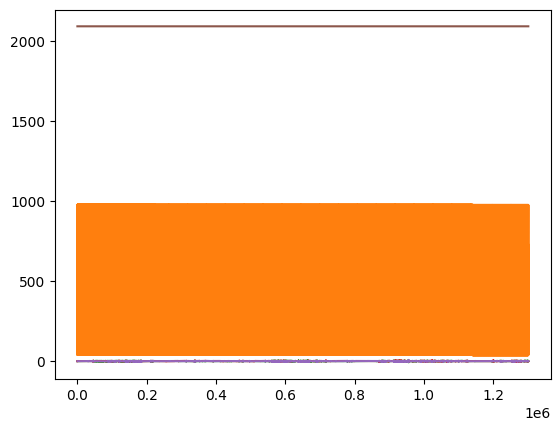

In [51]:
for i in range(np.shape(data)[1]):
    plt.plot(data[:, i])

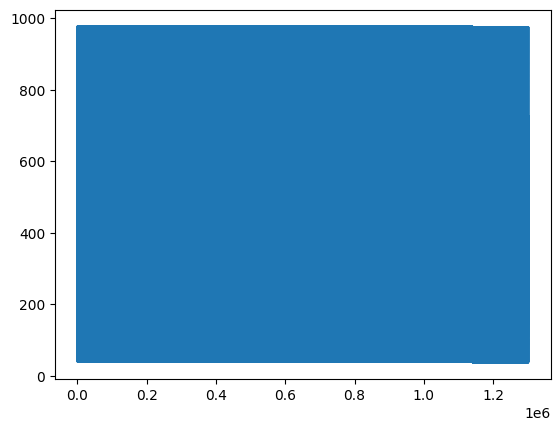

In [52]:
plt.plot(data[:,1])

## Plot Dataset Summary

The cells in this section should be able to run without editing. They just provide visualizations of some dataset properties.

In [53]:
# Count class representation

beh_names = dataset_metadata['label_names']
label_count = {fold : {name : 0 for name in beh_names} for fold in range(n_folds)}

for clip_id in clip_ids:
    clip_data_fp = os.path.join(clip_data_dir, clip_id + '.csv')
    data = pd.read_csv(clip_data_fp, delimiter = ',', header = None)
    counts = data[data.keys()[-1]].astype(int).value_counts()
    for key in counts.keys():
        name = beh_names[key]
        for fold in range(n_folds):
            if clip_id in dataset_metadata['clip_ids_per_fold'][fold]:
                label_count[fold][name] += counts[key]
                
label_perc = {fold : {name : 0 for name in beh_names[1:]} for fold in range(n_folds)}

for name in beh_names[1:]:
    for fold in range(n_folds):
        label_perc[fold][name] = float(label_count[fold][name] / sum([label_count[fold][j] for j in beh_names[1:]]))


ValueError: invalid literal for int() with base 10: 'NON_KILL'

In [55]:
# Plot class representation

# https://gist.github.com/thriveth/8560036#file-cbcolors-py
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

keys = np.arange(len(beh_names))[1:]
offset = 0.1
width = 0.1
plt.figure(figsize=(8, 6), dpi=80)

for fold in range(n_folds):
    current_offset = -(fold - n_folds // 2)*offset
    plt.barh(keys +current_offset, [label_perc[fold][beh_names[key]] for key in keys], height=width, align='center', label = fold, color = CB_color_cycle[fold])
    
plt.title("Class representation across folds")
plt.yticks(keys, beh_names[1:], fontsize = 7, rotation = 60)
plt.xlabel('Percent of known labels')
plt.legend()
target_fp = os.path.join(formatted_data_dir, 'class_rep.svg')

plt.savefig(target_fp, format = 'svg')
plt.show()

numerical_target_fp = os.path.join(formatted_data_dir, 'class_rep.yaml')
with open(numerical_target_fp, 'w') as file:
    yaml.dump(label_perc, file)

NameError: name 'label_perc' is not defined

<Figure size 640x480 with 0 Axes>

/tmp/ipykernel_7492/428991130.py:12: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)


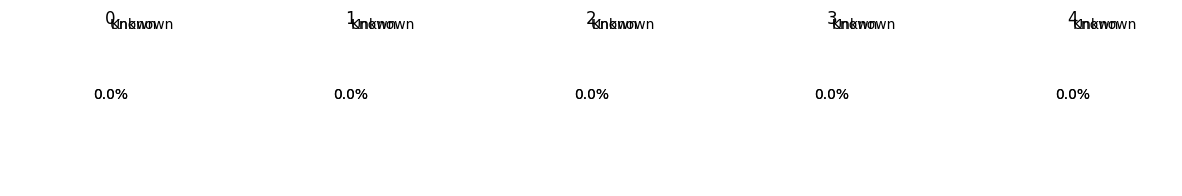

In [56]:
# Pie chart, of known vs unknown samples 

labels = 'Known', 'Unknown'
sizes = {fold : [sum([label_count[fold][j] for j in beh_names[1:]]), label_count[fold]['unknown']] for fold in range(n_folds)}
# train_sizes = [sum([train_label_count[j] for j in beh_names[1:]]), train_label_count['unknown']]
# val_sizes = [sum([val_label_count[j] for j in beh_names[1:]]), val_label_count['unknown']]
# test_sizes = [sum([test_label_count[j] for j in beh_names[1:]]), test_label_count['unknown']]

fig, ax = plt.subplots(1,n_folds, figsize = (3*n_folds,2))

for fold in range(n_folds):
    ax[fold].pie(sizes[fold], labels=labels, autopct='%1.1f%%', startangle=90)
    ax[fold].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax[fold].set_title(fold)

target_fp = os.path.join(formatted_data_dir, 'perc_known.svg')

plt.savefig(target_fp, format='svg')

plt.show()


## Temporal Statistics

This cell calculates the average duration of an annotation. It should run without needing to be edited, with the exception of the variable `infill_max_dur_sec`. This is only relevant in the situation where the annotations have regular gaps that should be filled in for the purpose of computing the average annotation duration. In the paper, this was only relevant for the Polar Bear dataset, because the annotations had regular gaps due to the video recording being duty-cycled (i.e. the camera turned off regularly to save battery). If this is not relevant for your dataset, leave `infill_max_dur_sec=0`.

In [57]:
####################################
infill_max_dur_sec = 0 # If annotations are nnnnn0000000nnnnn, where 0=unknown, do we fill in 0's with n's?
####################################

# This cell runs almost as a stand alone, but requires the first few cells of this notebook to be run first

import tqdm
from pathlib import Path

dataset_metadata_fp = os.path.join(formatted_data_dir, 'dataset_metadata.yaml')

with open(dataset_metadata_fp, 'r') as file:
    metadata = yaml.safe_load(file)

clip_fps = list(Path(clip_data_dir).glob('*.csv'))

def create_list_of_durations(x, infill_max_dur_sec, samplerate, unknown_value = 0):
    # First pass: create a list of label durations, together with a list of the associated classes
    current_value = 0
    current_dur = 0
    list_of_durs = []
    list_of_labels = []
    for i in x:
        if i == current_value:
            current_dur += 1
        elif i != current_value:
            list_of_durs.append(current_dur / samplerate)
            list_of_labels.append(current_value)
            current_dur = 1
            current_value = i
            
    list_of_durs.append(current_dur)
    list_of_labels.append(current_value)
            
    # repeatedly merge similar labels if they are seperated by unknowns of short duration
    # This is mainly to deal with duty cycling of observations
    infill_max_dur_samples = int(infill_max_dur_sec * samplerate)
    
    if list_of_labels[0] == unknown_value:
        del list_of_labels[0]
        del list_of_durs[0]
        
    if list_of_labels[-1] == unknown_value:
        del list_of_labels[-1]
        del list_of_durs[-1]
    
    j = 1
    while j<len(list_of_labels)-1:
        if list_of_labels[j] != unknown_value:
            j+= 1
        elif list_of_labels[j-1] == list_of_labels[j+1] and list_of_durs[j] < infill_max_dur_samples:
            # merge if it's a short interval of unknowns between two of the same label
            list_of_durs[j-1] += list_of_durs[j+1]
            del list_of_durs[j+1]
            del list_of_durs[j]
            del list_of_labels[j+1]
            del list_of_labels[j]
        else:
            # otherwise, drop the unknown segment
            del list_of_durs[j]
            del list_of_labels[j]

    return list_of_labels, list_of_durs # list of annotation durations, in samples.
                             
durs_sec_by_individual = {i : [] for i in metadata['individual_ids']}
overall_durs_sec = []
    
for fp in tqdm.tqdm(clip_fps):
    clip_id = fp.stem
    individual_id = metadata['clip_id_to_individual_id'][clip_id]
    clip_annotations = list(pd.read_csv(fp, header = None).values[:, -1])
    l, d = create_list_of_durations(clip_annotations, infill_max_dur_sec, metadata['sr'])
    durs_sec_by_individual[individual_id].extend(d)
    overall_durs_sec.extend(d)
    
mean_dur_sec_by_individual = {i : float(np.mean(durs_sec_by_individual[i])) for i in durs_sec_by_individual}
mean_overall_dur_sec = float(np.mean(overall_durs_sec))

metadata['mean_dur_sec_by_individual'] = mean_dur_sec_by_individual
metadata['mean_overall_dur_sec'] = mean_overall_dur_sec

print("Mean overall label duration is %0.3f seconds" % mean_overall_dur_sec)

print("Re-saving metadata to %s" % str(dataset_metadata_fp))

with open(dataset_metadata_fp, 'w') as file:
    yaml.dump(metadata, file)

100%|██████████| 15/15 [00:06<00:00,  2.43it/s]

Mean overall label duration is 56657.858 seconds
Re-saving metadata to /home/matthew/AI_Capstone/ai-capstone/BEBE-datasets/format_cougar_split/dataset_metadata.yaml
